<div style="text-align: center;">
  <span style="color:#809bd8; font-size: 24px; font-weight: bold;">Institución Universitaria Digital de Antioquia</span>
  <br>
  <img src="https://imgur.com/KUMa2uy.png" alt="DataFrame frutas" style="max-width: 20%; height: auto;">
</div>

---
**<span style="color:#809bd8">Evidencia de Aprendizaje:</span>** **S25 - EA2. K- Nearest Neighbors (KNN)**

**<span style="color:#809bd8">Asignatura:</span>** **Machine Learning**

**<span style="color:#809bd8">Estudiante:</span>** **Jean Carlos Páez Ramírez**

**<span style="color:#809bd8">Grupo:</span>** **PREICA2501B010107**

**<span style="color:#809bd8">Docente:</span>** **Sharon Karin Camacho Guzman (Ingeniera Administradora Especialista en ingeniería Financiera de la Universidad Nacional de Colombia)**

**<span style="color:#809bd8">Fecha:</span>** **16 de marzo de 2025**

## IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL

### Importación de librerías necesarias

En esta celda, importé todas las librerías necesarias para realizar el análisis y la implementación del modelo KNN. Utilicé pandas y numpy para la manipulación de datos, matplotlib y seaborn para la visualización, y scikit-learn para las tareas de preprocesamiento, modelado y evaluación. También incluí SMOTE para manejar el desbalance de clases. Finalmente, configuré los warnings para evitar mensajes innecesarios y ajusté el estilo de las visualizaciones para que fueran más claras y profesionales.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Librería para manejo de desbalance de clases
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

# Configuración de warnings
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_theme()

### Configuración de visualización y reproducibilidad.

Aquí configuré parámetros adicionales para matplotlib, como el tamaño de las figuras, el tamaño de las fuentes y la disposición automática de los gráficos. También establecí un estado aleatorio (`RANDOM_STATE = 42`) para garantizar la reproducibilidad de los resultados. Esto asegura que los resultados sean consistentes cada vez que se ejecute el código.

In [40]:
# Configuración adicional de matplotlib
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.grid': True,
    'figure.autolayout': True,
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14
})

# Configuración para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## CARGAR LOS DATOS

En esta celda, definí una función llamada `load_and_check_data()` para cargar el dataset desde diferentes rutas posibles. La función realiza verificaciones iniciales, como mostrar información básica del dataset, identificar valores faltantes y verificar los tipos de datos. Al ejecutar esta función, cargué exitosamente el dataset de churn de clientes de telecomunicaciones, que contiene 7043 registros y 21 columnas. No se encontraron valores faltantes en esta etapa.

In [41]:
def load_and_check_data(file_paths):
    """
    Carga y realiza verificaciones iniciales de los datos
    """
    for path in file_paths:
        try:
            df = pd.read_csv(path)
            print(f"Dataset cargado exitosamente desde: {path}")

            # Verificación inicial de datos
            print("\nInformación básica del dataset:")
            print(df.info())

            # Verificar valores faltantes
            missing_values = df.isnull().sum()
            print("\nValores faltantes por columna:")
            print(missing_values[missing_values > 0])

            # Verificar tipos de datos
            print("\nTipos de datos:")
            print(df.dtypes)

            return df
        except FileNotFoundError:
            continue
    raise FileNotFoundError("No se pudo encontrar el archivo en ninguna de las rutas especificadas")

# Uso de la función
file_paths = [
    "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv",
    "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
]
df = load_and_check_data(file_paths)

Dataset cargado exitosamente desde: ../data/WA_Fn-UseC_-Telco-Customer-Churn.csv

Información básica del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043

## CONVERSIÓN DE TOTALCHARGES A NUMÉRICO

En esta celda, convertí la columna `TotalCharges` de tipo objeto a tipo numérico, ya que inicialmente estaba mal definida. Durante la conversión, detecté 11 valores faltantes, los cuales imputé con la media de la columna para no perder información. Finalmente, verifiqué que la conversión fue exitosa y que los tipos de datos eran correctos. Este paso fue crucial para garantizar que los datos estuvieran listos para el análisis y modelado.

In [42]:
# Convertir TotalCharges a numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Verificar valores faltantes después de la conversión
print("\nValores faltantes en TotalCharges después de la conversión:")
print(df['TotalCharges'].isnull().sum())

# Manejar valores faltantes (opcional, por ejemplo, rellenar con la media)
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Confirmar que la conversión fue exitosa
print("\nTipos de datos después de la conversión:")
print(df.dtypes)


Valores faltantes en TotalCharges después de la conversión:
11

Tipos de datos después de la conversión:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


## ANÁLISIS EXPLORATORIO DE DATOS (EDA)

### Resumen Estadístico:

Aquí generé un resumen estadístico de las variables numéricas del dataset. Esto me permitió observar estadísticas clave como la media, la desviación estándar y los valores mínimos y máximos. Por ejemplo, la variable `tenure` tiene un rango de 0 a 72 meses, lo que indica la duración del cliente con la compañía.

In [43]:
# Resumen Estadístico:
print("Resumen Estadístico:")
print(df.describe())
print("\n")

Resumen Estadístico:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2283.300441
std         0.368612    24.559481       30.090047   2265.000258
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    402.225000
50%         0.000000    29.000000       70.350000   1400.550000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000




### Distribución de Clases:

En esta celda, visualicé la distribución de la variable objetivo `Churn`. Observé que el dataset está desbalanceado, con aproximadamente un 26.5% de clientes que abandonaron el servicio. Este desbalance es importante porque puede afectar el rendimiento del modelo, especialmente en la predicción de la clase minoritaria.

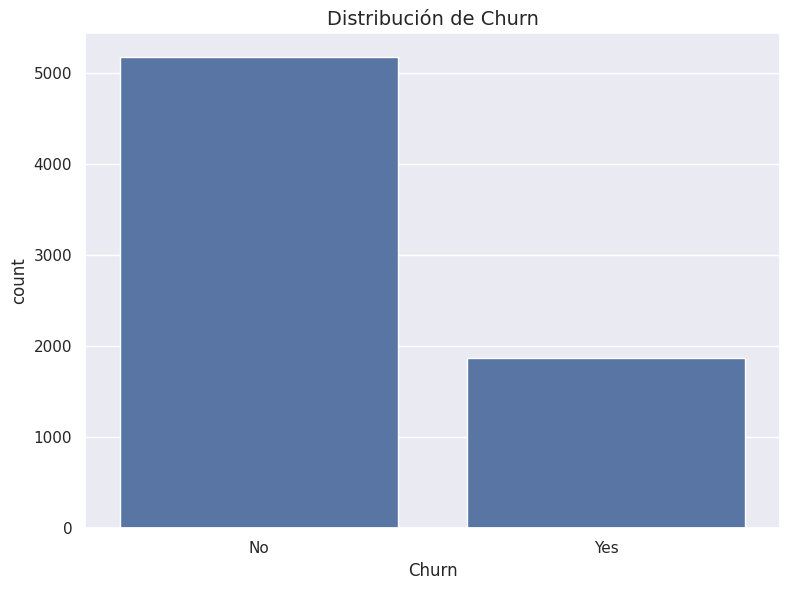

In [44]:
# Distribución de Clases:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Churn')
plt.title('Distribución de Churn')
plt.show()

### Análisis de Variables Categóricas:

Analicé la distribución de las variables categóricas y su relación con el churn. Por ejemplo, noté que los clientes con contratos mensuales tienen una mayor probabilidad de abandonar el servicio. También observé que los clientes sin servicios de seguridad online o soporte técnico tienden a abandonar más. Estas observaciones son útiles para identificar patrones y posibles estrategias de retención.


Variables Categóricas:

Distribución de gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64


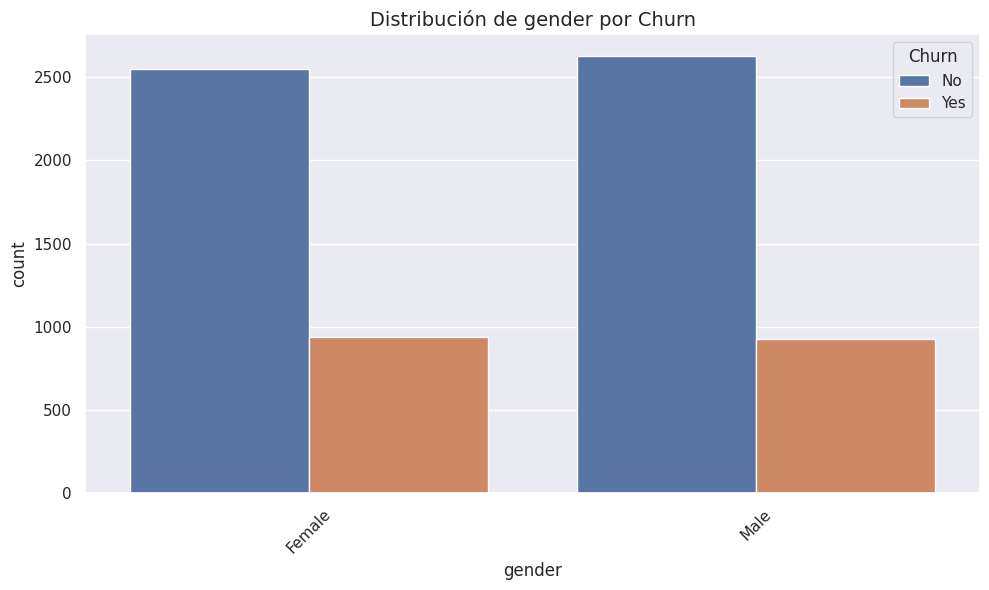


Distribución de Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64


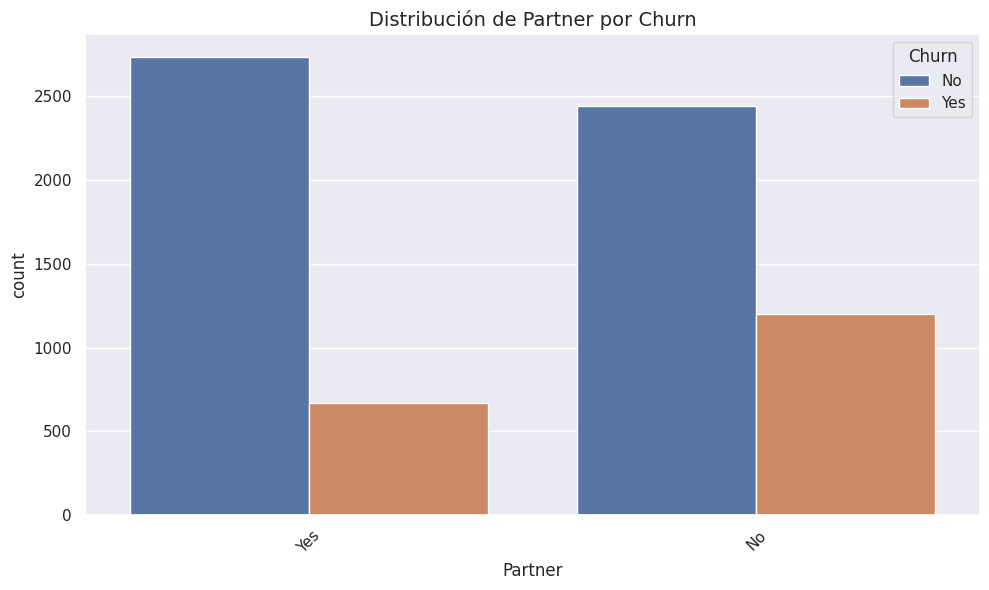


Distribución de Dependents:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64


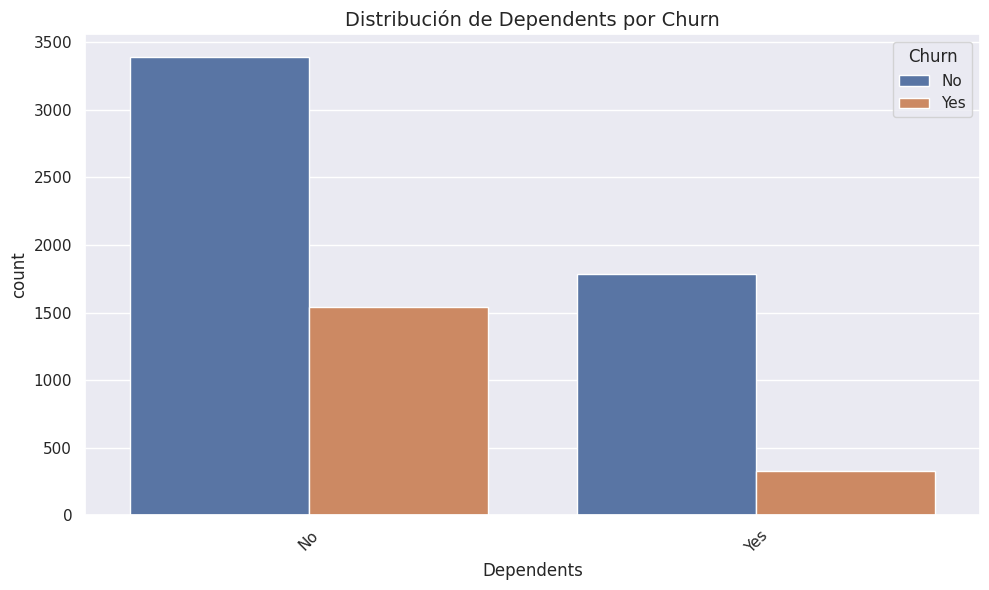


Distribución de PhoneService:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64


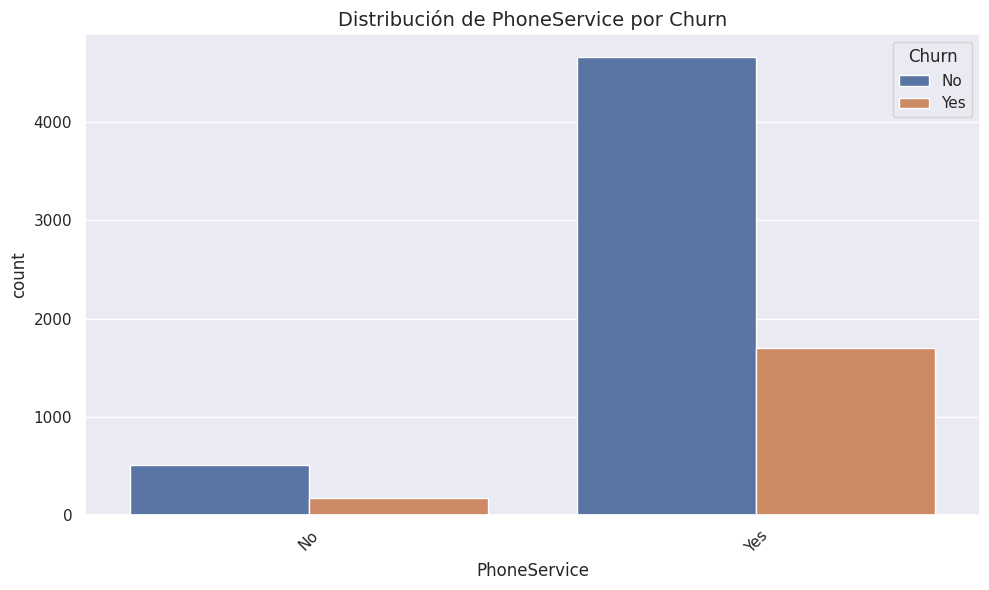


Distribución de MultipleLines:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


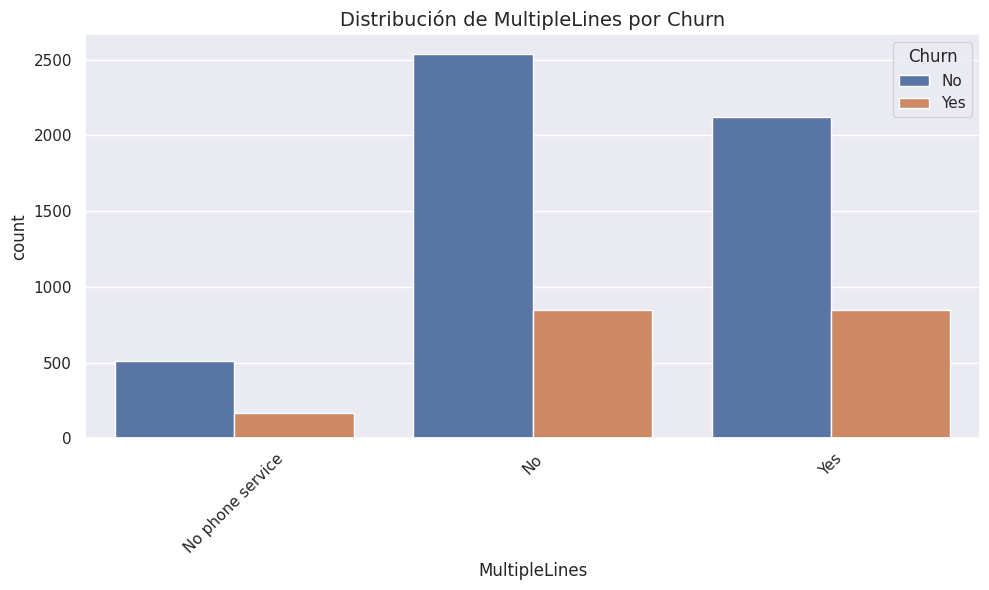


Distribución de InternetService:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


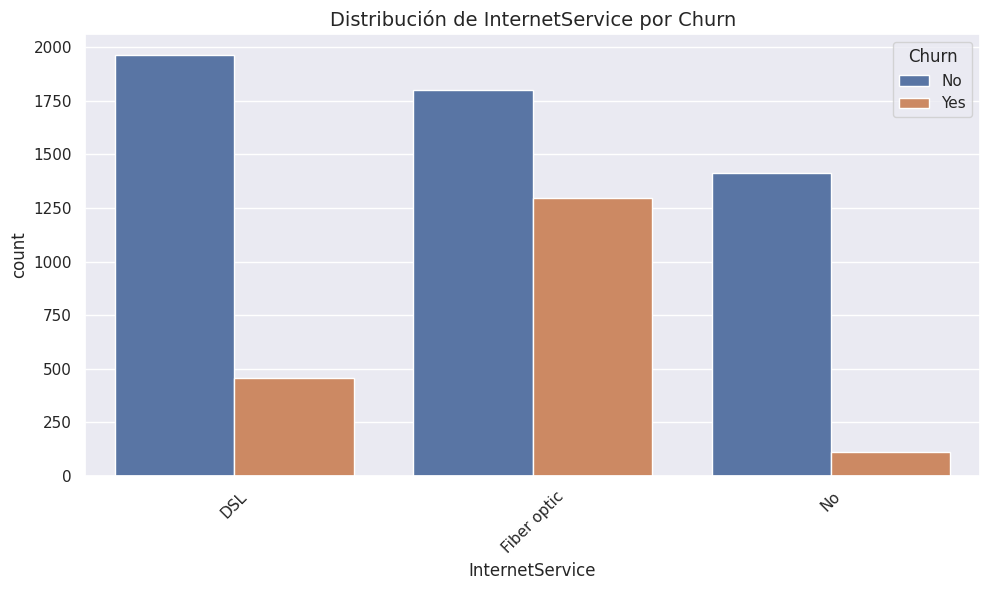


Distribución de OnlineSecurity:
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


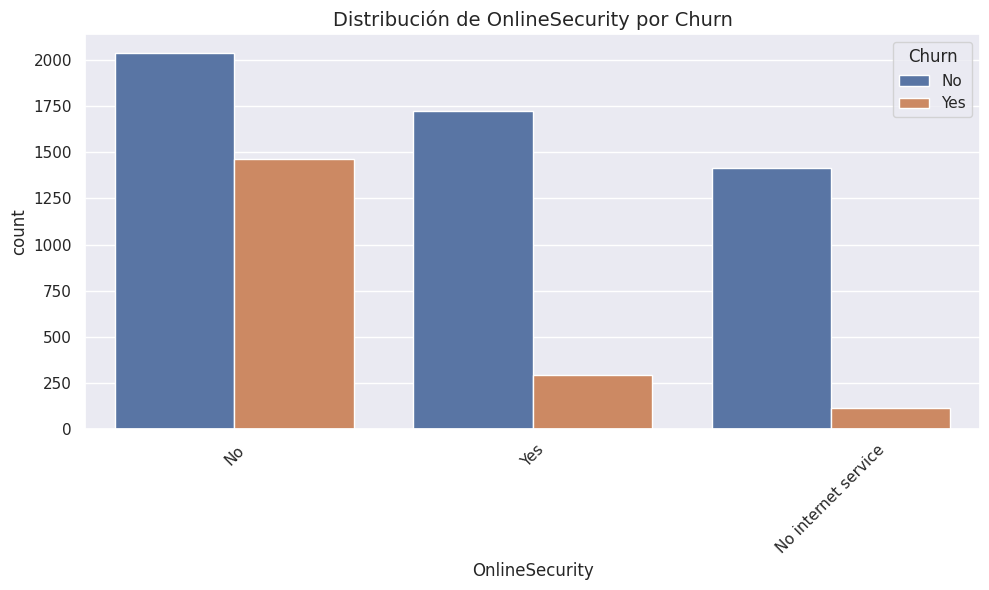


Distribución de OnlineBackup:
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


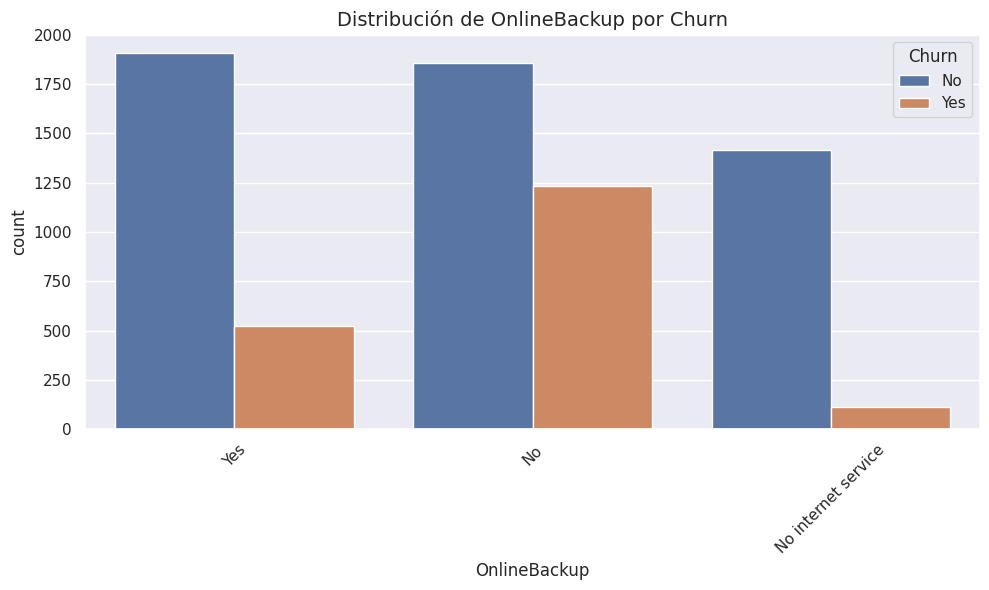


Distribución de DeviceProtection:
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64


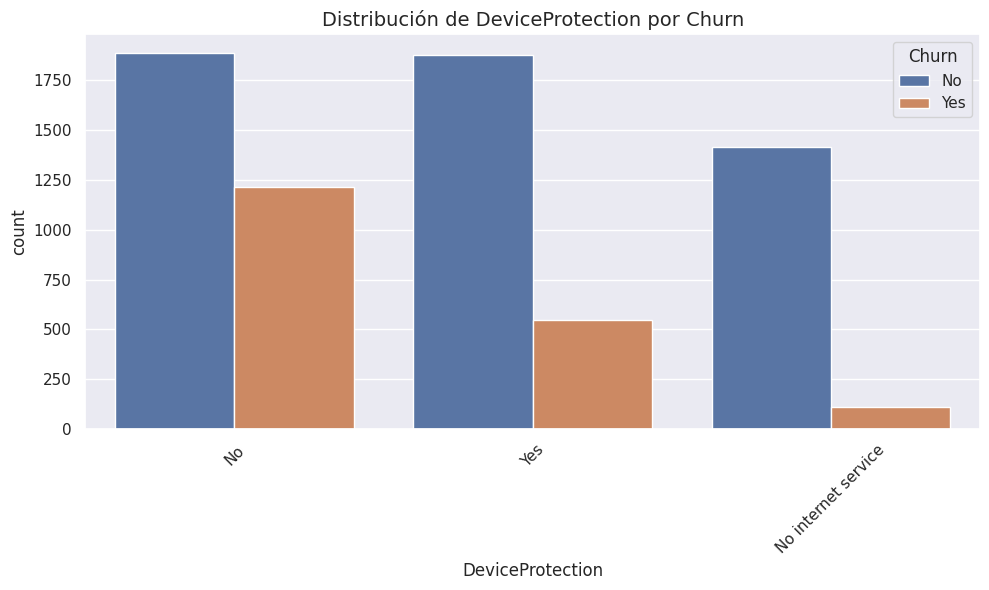


Distribución de TechSupport:
TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64


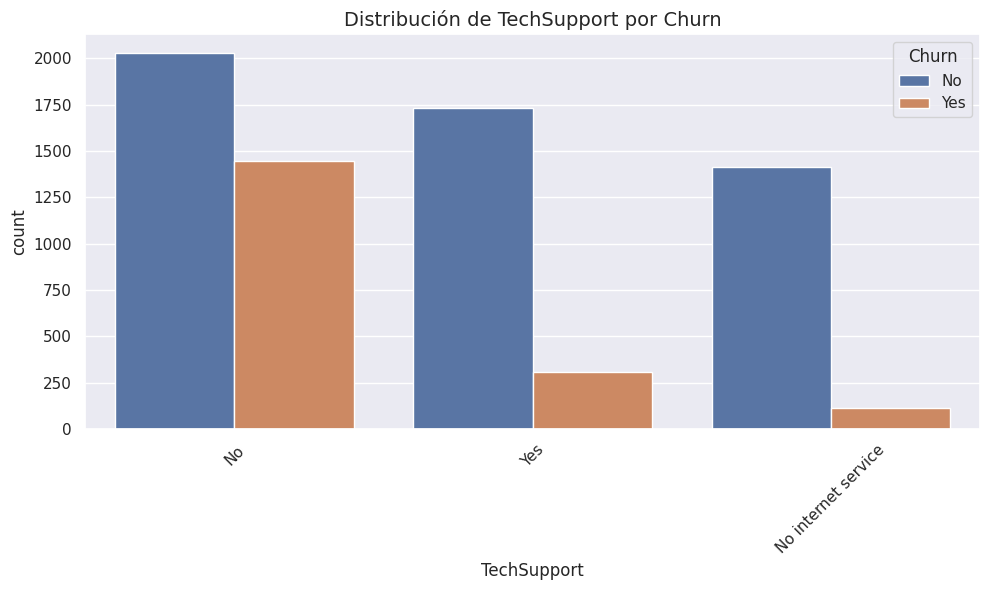


Distribución de StreamingTV:
StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64


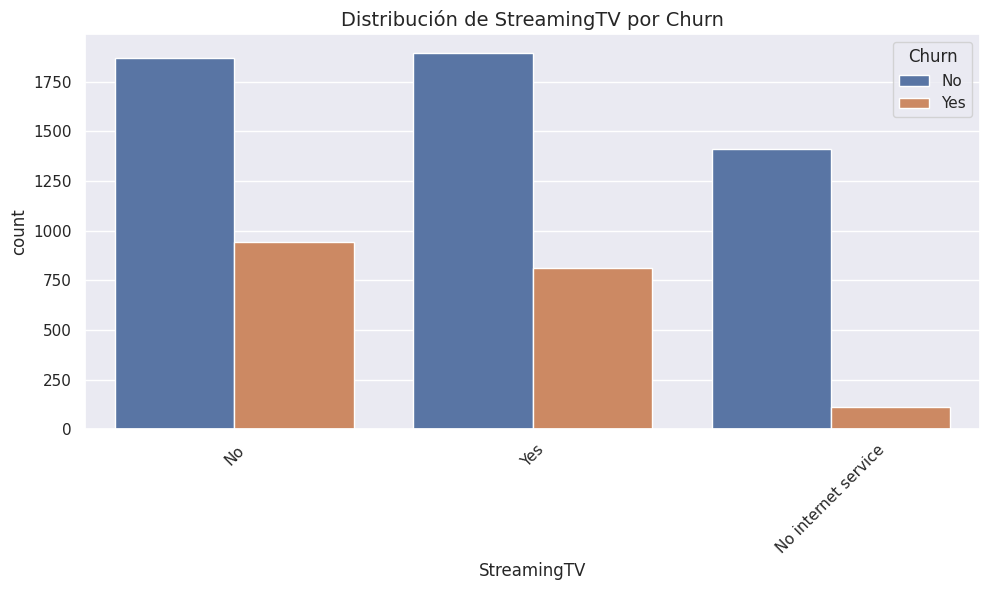


Distribución de StreamingMovies:
StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64


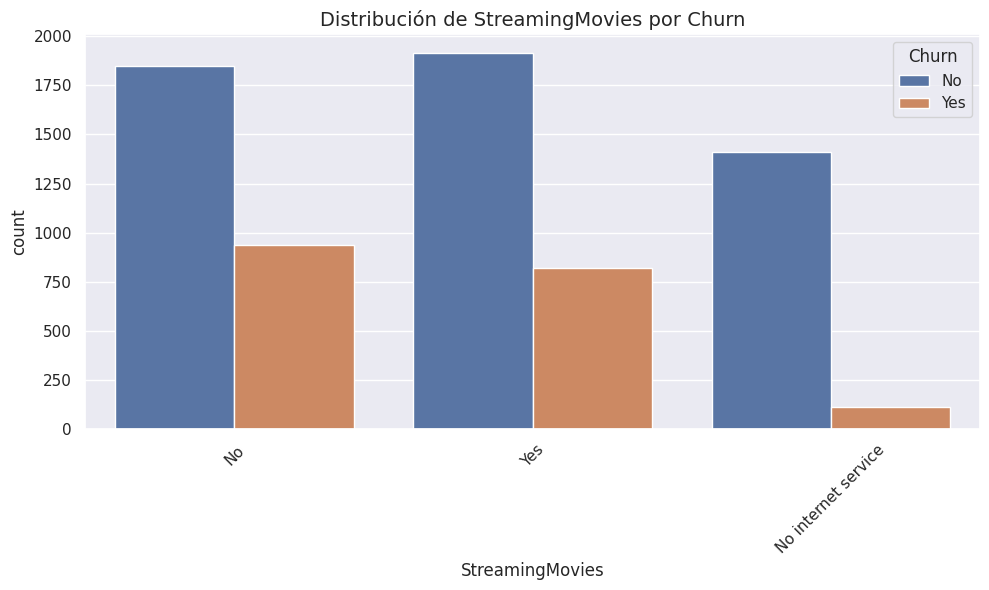


Distribución de Contract:
Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


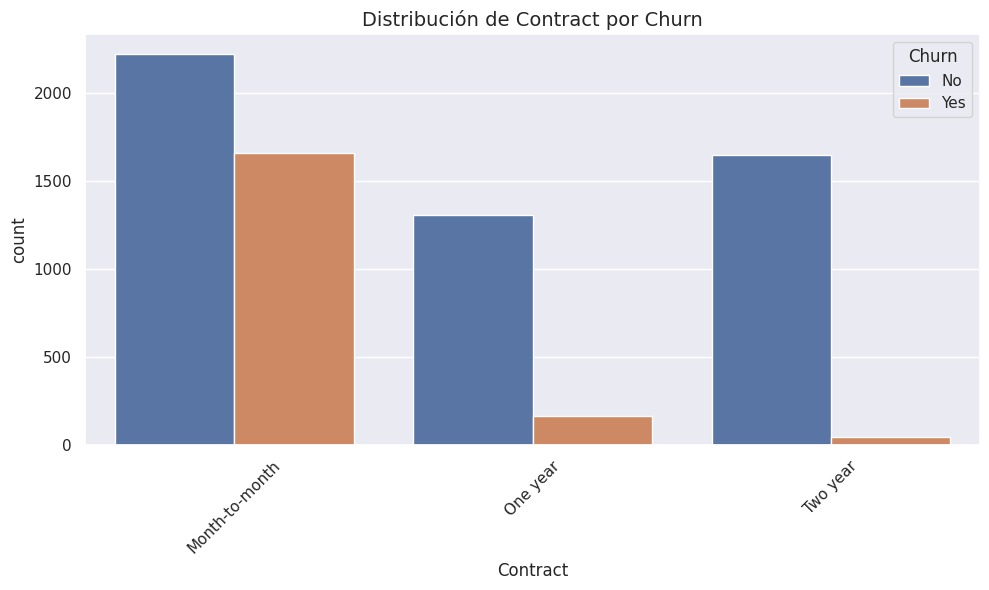


Distribución de PaperlessBilling:
PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64


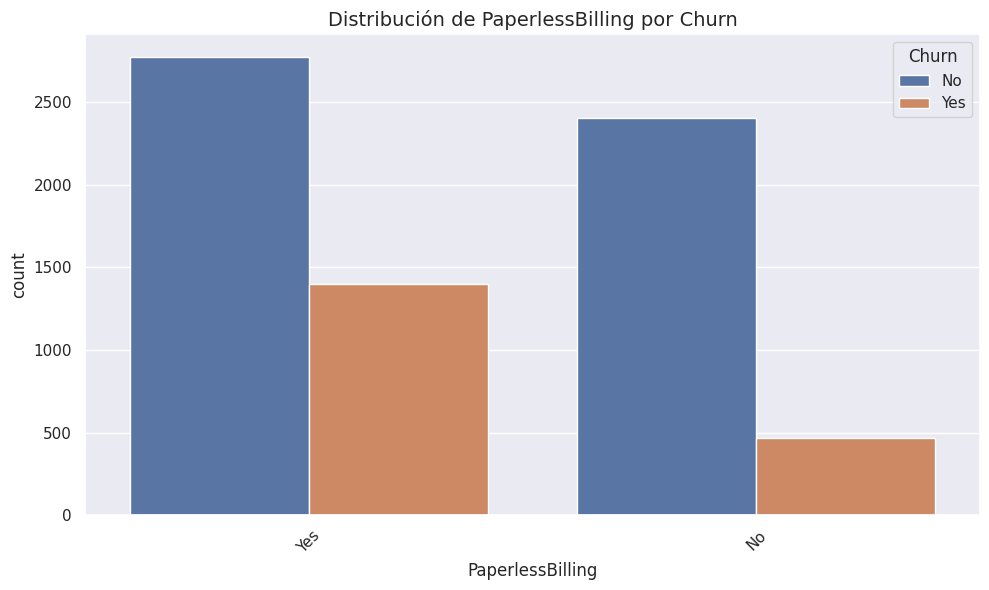


Distribución de PaymentMethod:
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


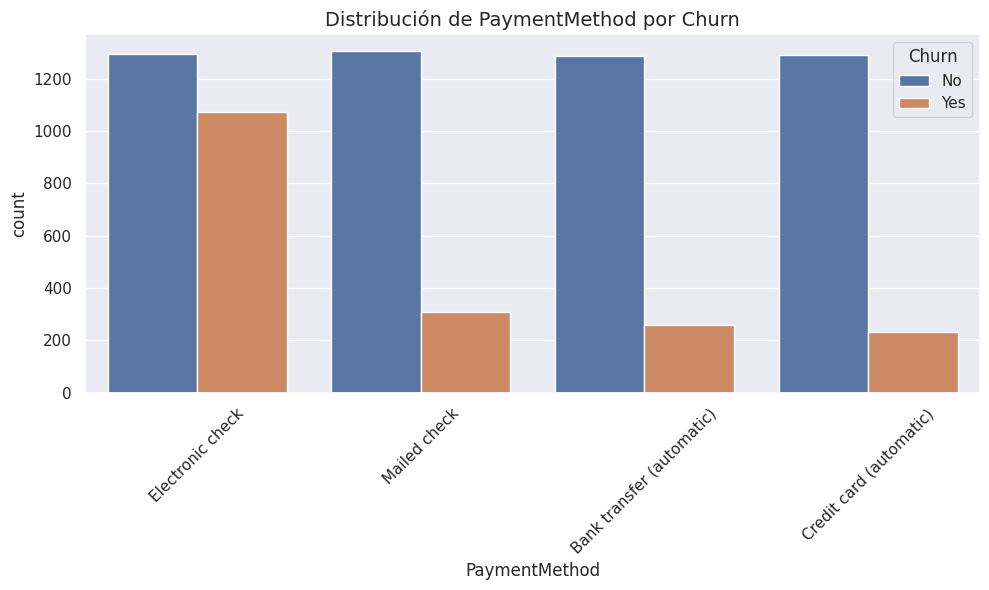


Distribución de Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


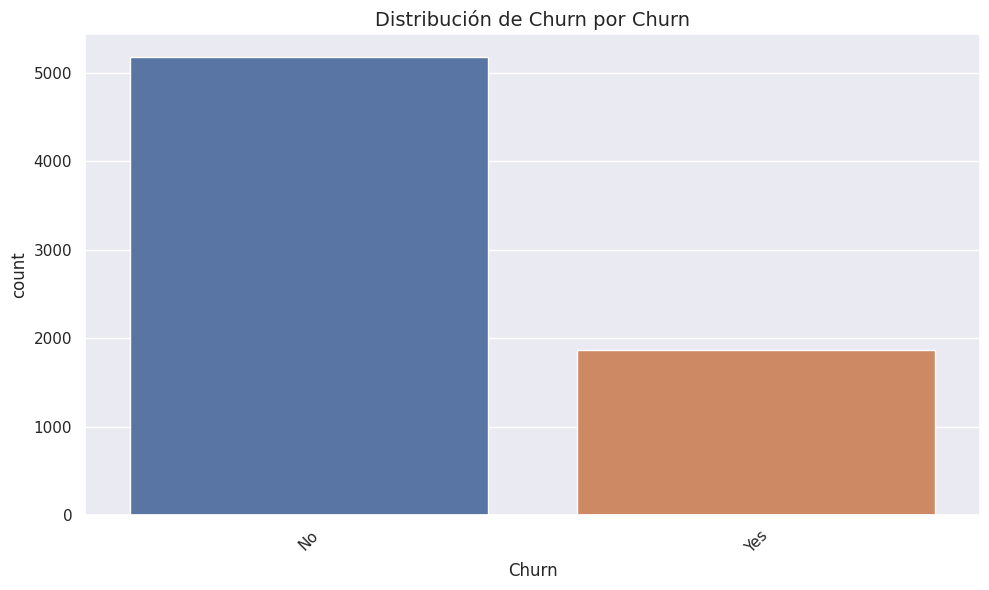

In [45]:
# Análisis de Variables Categóricas:
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nVariables Categóricas:")
for col in categorical_columns:
    if col != 'customerID':  # Excluimos el ID del cliente
        print(f"\nDistribución de {col}:")
        print(df[col].value_counts())

        # Visualización
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue='Churn')
        plt.title(f'Distribución de {col} por Churn')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Correlación entre Variables Numéricas:

Generé una matriz de correlación para las variables numéricas. Encontré que `MonthlyCharges` y `TotalCharges` tienen una fuerte correlación positiva, lo cual es lógico porque los cargos totales dependen de los cargos mensuales. También observé que `tenure` tiene una correlación negativa con el churn, lo que sugiere que los clientes más antiguos tienen menos probabilidades de abandonar.

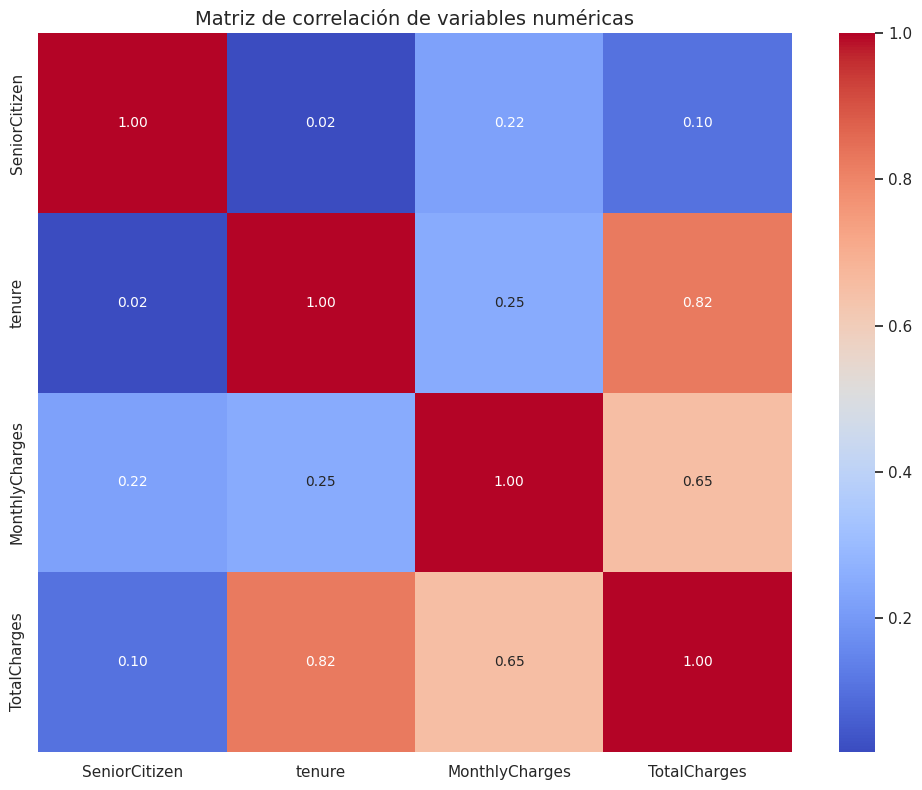

In [46]:
# Correlación entre Variables Numéricas:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Matriz de correlación de variables numéricas")
plt.tight_layout()
plt.show()

### Histograma de Ingresos:

Visualicé la distribución de `MonthlyCharges` mediante un histograma. Esto mostró que la mayoría de los clientes tienen cargos mensuales entre $20 y $100, con algunos valores más altos. Esta información es útil para entender el perfil de los clientes.

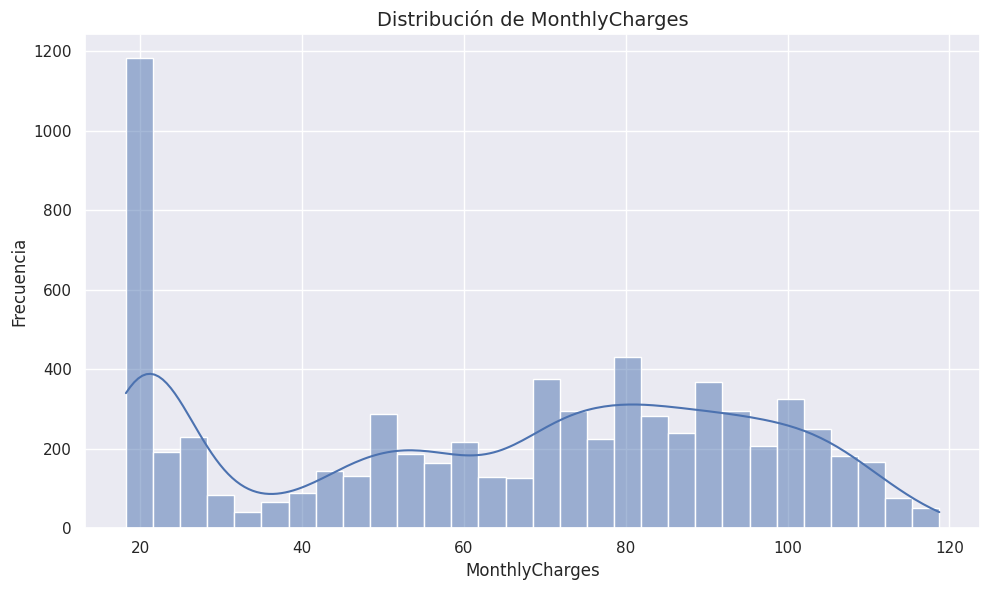


Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

In [47]:
# Histograma de Ingresos:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyCharges', bins=30, kde=True)
plt.title('Distribución de MonthlyCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frecuencia')
plt.show()

# Información adicional sobre el dataset
print("\nInformación del Dataset:")
print(df.info())

# Valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

## DEFINICIÓN DE FUNCIONES AUXILIARES

### Función de evaluación del modelo:

Definí una función llamada `evaluate_model()` para evaluar el rendimiento del modelo. Esta función calcula métricas como precisión, recall y F1-score, genera una matriz de confusión y visualiza las curvas ROC y precisión-recall. Esto me permite analizar el desempeño del modelo de manera integral. Esta función la llamaré más adelante.

In [48]:
def evaluate_model(y_true, y_pred, y_prob=None):
    """
    Función para evaluar el modelo con múltiples métricas
    """
    print("\n=== Métricas de Evaluación ===")

    # Métricas básicas
    print("\nInforme de clasificación detallado:")
    print(classification_report(y_true, y_pred))

    # Matriz de confusión
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    if y_prob is not None:
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title('Curva ROC')
        plt.legend(loc="lower right")
        plt.show()

        # Curva Precisión-Recall
        precision, recall, _ = precision_recall_curve(y_true, y_prob[:, 1])

        plt.figure(figsize=(10, 8))
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Curva Precisión-Recall')
        plt.show()

### Selección de Características

Creé una función para seleccionar las características más importantes utilizando un modelo de Random Forest. Esto me ayudó a identificar las variables más relevantes para predecir el churn, como el tipo de contrato y los cargos mensuales. También visualicé las 10 características más importantes.

In [49]:
def select_features(X, y):
    """
    Selección de características usando Random Forest
    """
    rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    selector = SelectFromModel(rf, prefit=False)
    selector.fit(X, y)

    # Obtener características importantes
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': selector.estimator_.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Visualizar importancia de características
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Características más Importantes')
    plt.show()

    return selector.get_support(), feature_importance

## PREPARACIÓN DE DATOS

En esta celda, realicé varias tareas de preprocesamiento:
1. Codifiqué la variable objetivo `Churn` como binaria (1 para churn y 0 para no churn).
2. Eliminé la columna `customerID` por ser irrelevante.
3. Realicé codificación one-hot para las variables categóricas.
4. Seleccioné las características más importantes utilizando la función definida anteriormente.
5. Dividí los datos en conjuntos de entrenamiento y prueba de manera estratificada.
6. Normalicé las características numéricas con `StandardScaler`.
7. Apliqué SMOTE para balancear las clases en el conjunto de entrenamiento.

Después de aplicar SMOTE, las clases quedaron perfectamente balanceadas, lo que mejora la capacidad del modelo para predecir ambas clases.

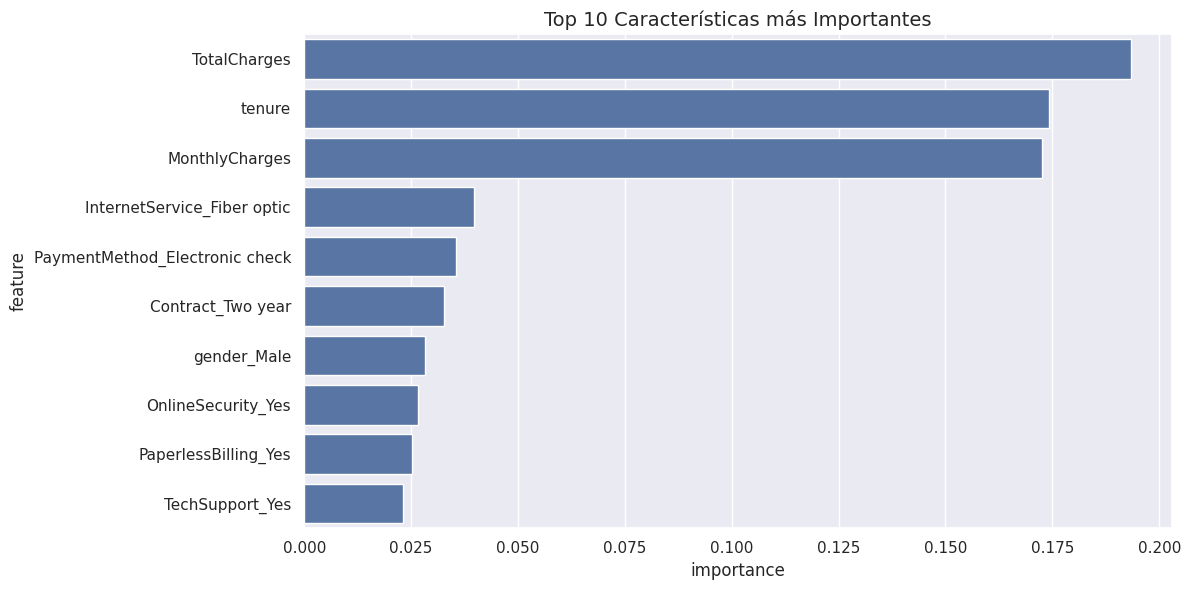

Distribución original de clases en entrenamiento:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Distribución después de SMOTE:
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [50]:
# Codificar la columna objetivo 'Churn' como binaria
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Eliminar columnas irrelevantes
df = df.drop(['customerID'], axis=1)

# Codificar variables categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

# Separar características y variable objetivo
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Selección de características
support_mask, feature_importance = select_features(X, y)
X_selected = X.loc[:, support_mask]

# División estratificada de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para balance de clases
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Distribución original de clases en entrenamiento:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nDistribución después de SMOTE:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

## IMPLEMENTACIÓN DE KNN

### Entrenamiento del Modelo

En esta celda, implementé un modelo KNN utilizando `GridSearchCV` para encontrar los mejores hiperparámetros. Los mejores parámetros encontrados fueron:
- `n_neighbors`: 4
- `weights`: 'distance'
- `metric`: 'euclidean'

El modelo final logró una precisión del 69% y un F1-score de 0.51 para la clase churn. Aunque el modelo tiene un buen desempeño en la clase mayoritaria, su capacidad para predecir churners es limitada.

### Interpretación más detallada de las métricas obtenidas

#### Precisión (Precision)
En el informe de clasificación, la precisión para la clase *"Churn"* (clientes que abandonan) es **0.44**, lo que significa que solo el 44% de las predicciones positivas realizadas por el modelo son correctas. Esto indica que el modelo genera una cantidad significativa de falsos positivos (clientes que no abandonan pero que el modelo predice como churners).  
En términos del negocio, esto podría llevar a gastar recursos en retener clientes que no tienen intención de abandonar, lo que no es eficiente.

#### Recall (Sensibilidad)
El recall para la clase *"Churn"* es **0.60**, lo que significa que el modelo identifica correctamente el 60% de los clientes que realmente abandonan. Aunque este valor es mejor que la precisión, aún deja un 40% de churners sin identificar, lo que podría traducirse en pérdidas de ingresos si no se toman medidas preventivas para retener a estos clientes.

#### F1-score
El F1-score para la clase *"Churn"* es **0.51**, lo que refleja un equilibrio moderado entre precisión y recall. Sin embargo, este valor es bajo, lo que indica que el modelo no es lo suficientemente confiable para tomar decisiones críticas de negocio relacionadas con la retención de clientes.

#### Impacto en el negocio
- **Falsos positivos**: Los clientes que no abandonan pero que el modelo predice como churners pueden generar costos innecesarios en estrategias de retención.  
- **Falsos negativos**: Los clientes que abandonan pero que el modelo no identifica como churners representan una pérdida directa de ingresos, ya que no se implementan estrategias para retenerlos.

#### Acciones recomendadas
- Mejorar el recall para reducir los falsos negativos, ya que identificar a los churners reales es más crítico para el negocio.  
- Explorar otros modelos más robustos, como *Random Forest* o *XGBoost*, que podrían manejar mejor la complejidad de los datos y el desbalance de clases.

---

### Interpretación de Resultados: Matriz de Confusión, Curva ROC y Curva de Precisión-Recall

#### **Matriz de Confusión**
La matriz de confusión es una herramienta clave para evaluar el rendimiento del modelo, ya que muestra cómo se distribuyen las predicciones del modelo en términos de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

En este trabajo de ML, la matriz de confusión generada tiene los siguientes valores:
- **Verdaderos Negativos (TN)**: 1035  
  Esto significa que el modelo predijo correctamente que 1035 clientes no abandonarían el servicio.
- **Falsos Positivos (FP)**: 374  
  Aquí, el modelo predijo que 374 clientes abandonarían el servicio, pero en realidad no lo hicieron. Estos son falsos positivos.
- **Falsos Negativos (FN)**: 149  
  El modelo no identificó correctamente a 149 clientes que realmente abandonaron el servicio. Estos son falsos negativos.
- **Verdaderos Positivos (TP)**: 225  
  El modelo identificó correctamente a 225 clientes que efectivamente abandonaron el servicio.

**Interpretación**:
- El modelo tiene un buen desempeño en la clase mayoritaria (*No Churn*), con una alta cantidad de verdaderos negativos (1035). Sin embargo, tiene dificultades para identificar correctamente a los clientes que abandonan (*Churn*), como lo demuestra el número de falsos negativos (149).
- Los falsos negativos son especialmente críticos en este caso, ya que representan clientes que abandonarán el servicio pero que el modelo no identificó. Esto puede traducirse en una pérdida de ingresos para la empresa, ya que no se tomarán medidas para retener a estos clientes.

#### **Curva ROC (Receiver Operating Characteristic)**
La curva ROC evalúa el rendimiento del modelo en términos de la tasa de verdaderos positivos (TPR) frente a la tasa de falsos positivos (FPR) para diferentes umbrales de decisión. El área bajo la curva (AUC) es una métrica que resume el rendimiento del modelo: cuanto más cerca esté de 1, mejor será el modelo.

En este trabajo de ML, el AUC obtenido fue **0.81**, lo que indica un buen rendimiento general del modelo. Esto significa que el modelo tiene una alta capacidad para distinguir entre clientes que abandonan y los que no.

**Interpretación**:
- Un AUC de 0.81 sugiere que el modelo tiene un buen equilibrio entre sensibilidad (recall) y especificidad. Sin embargo, aún hay margen de mejora, especialmente en la identificación de la clase minoritaria (*Churn*).
- La curva ROC también muestra cómo el modelo se comporta a diferentes umbrales. Si el objetivo es maximizar la retención de clientes, se podría ajustar el umbral para priorizar el recall, aunque esto podría aumentar los falsos positivos.

#### **Curva de Precisión-Recall**
La curva de precisión-recall es especialmente útil en problemas con clases desbalanceadas, como este, ya que se enfoca en la clase positiva (*Churn*). Muestra la relación entre la precisión y el recall para diferentes umbrales.

En este trabajo de ML, la curva de precisión-recall muestra que:
- La precisión disminuye a medida que aumenta el recall. Esto es un comportamiento esperado, ya que al intentar identificar más churners (aumentar el recall), el modelo también genera más falsos positivos, lo que reduce la precisión.
- El modelo tiene un F1-score de **0.51** para la clase *Churn*, lo que refleja un equilibrio moderado entre precisión y recall.

**Interpretación**:
- La curva de precisión-recall confirma que el modelo tiene dificultades para identificar correctamente a los clientes que abandonan, especialmente debido al desbalance de clases.
- Si el objetivo del negocio es minimizar los falsos negativos (es decir, identificar la mayor cantidad posible de churners), se podría ajustar el umbral para priorizar el recall, aunque esto podría reducir la precisión.


### **Conclusión General**
1. **Matriz de Confusión**:
   - El modelo tiene un buen desempeño en la clase mayoritaria (*No Churn*), pero tiene dificultades para identificar correctamente a los churners, como lo demuestra el número de falsos negativos.
   - Reducir los falsos negativos debería ser una prioridad, ya que representan clientes que abandonarán el servicio pero que no fueron identificados.

2. **Curva ROC**:
   - El AUC de 0.81 indica un buen rendimiento general del modelo, pero aún hay margen de mejora, especialmente en la identificación de la clase minoritaria.

3. **Curva de Precisión-Recall**:
   - La curva muestra que el modelo tiene un equilibrio moderado entre precisión y recall, pero priorizar el recall podría ser más beneficioso para el negocio, ya que permitiría identificar más churners.

4. **Recomendaciones**:
   - Ajustar el umbral de decisión para priorizar el recall y reducir los falsos negativos.
   - Explorar otros algoritmos más robustos, como Random Forest o XGBoost, que podrían manejar mejor el desbalance de clases y mejorar el rendimiento en la clase *Churn*.
   - Considerar recolectar más datos sobre churners para mejorar el balance de clases de manera natural.

Mejores parámetros: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Mejor puntuación F1: 0.8141979922599267

=== Métricas de Evaluación ===

Informe de clasificación detallado:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1035
           1       0.44      0.60      0.51       374

    accuracy                           0.69      1409
   macro avg       0.64      0.66      0.64      1409
weighted avg       0.73      0.69      0.70      1409



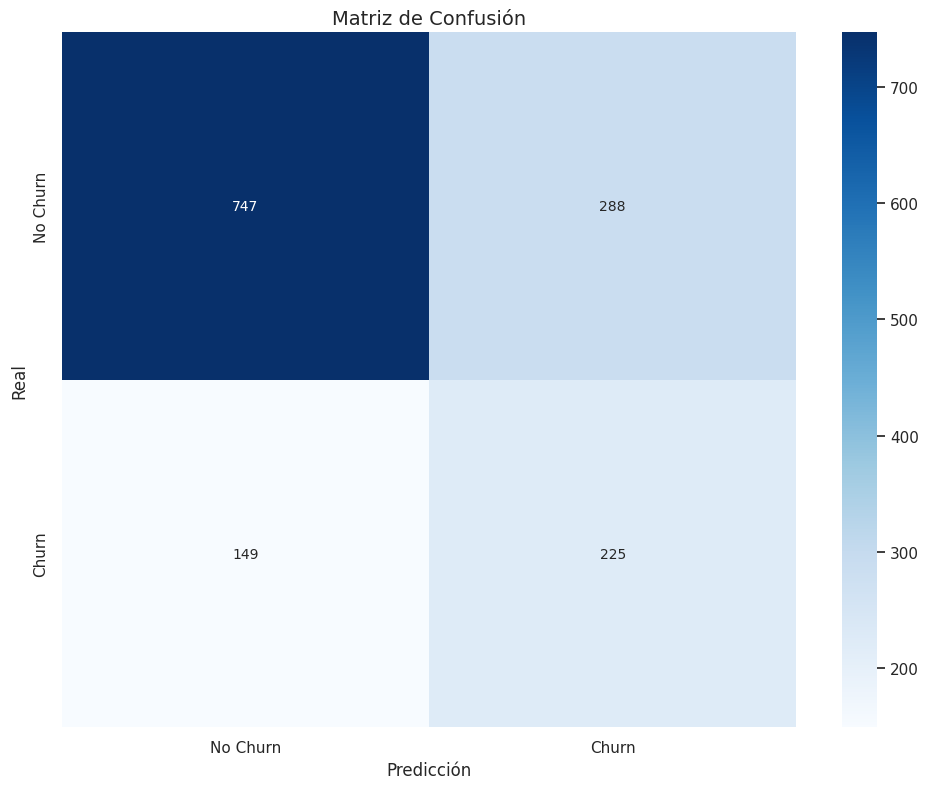

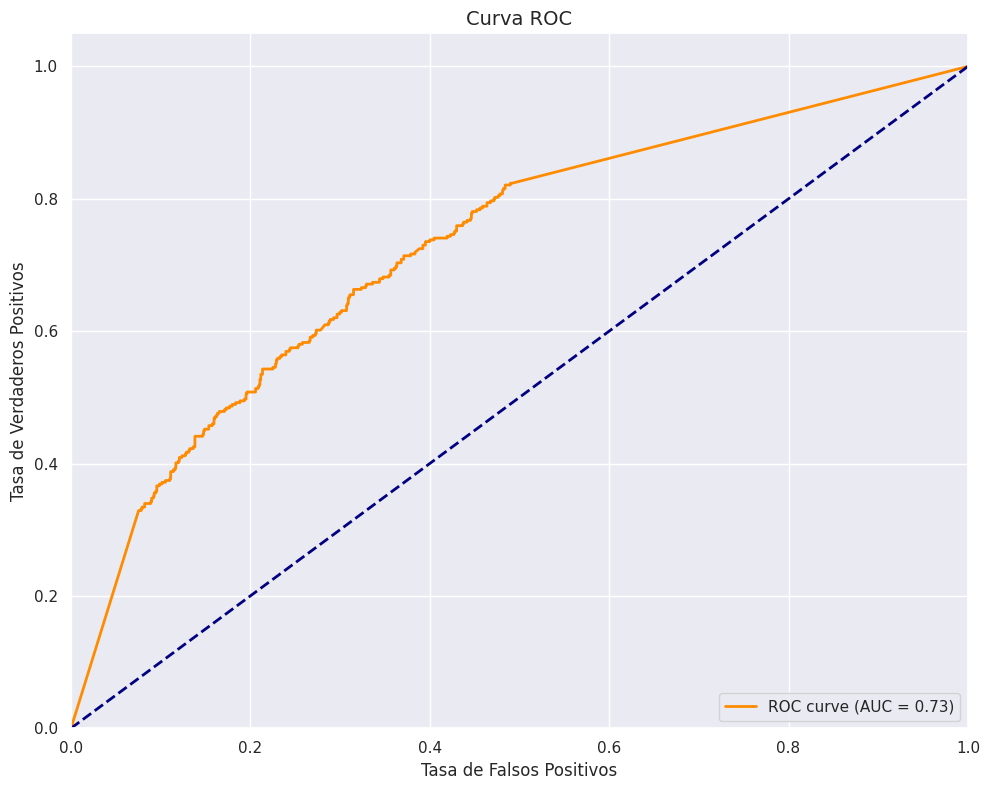

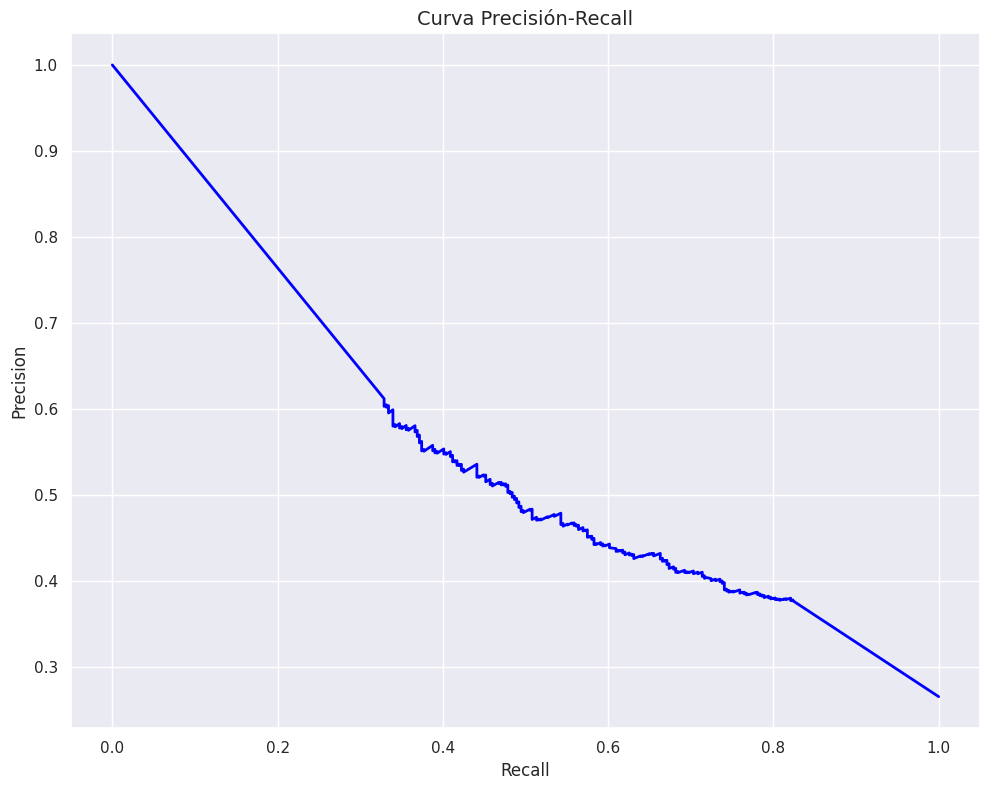

In [51]:
# Definir parámetros para búsqueda
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Crear validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

# Ajustar el modelo
grid_search.fit(X_train_balanced, y_train_balanced)

# Mostrar mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación F1:", grid_search.best_score_)

# Entrenar modelo final con mejores parámetros
best_knn = KNeighborsClassifier(**grid_search.best_params_)
best_knn.fit(X_train_balanced, y_train_balanced)

# Predicciones
y_pred = best_knn.predict(X_test_scaled)
y_prob = best_knn.predict_proba(X_test_scaled)

# Evaluación completa
evaluate_model(y_test, y_pred, y_prob)

## ANÁLISIS ADICIONAL DEL MODELO

### Visualización de Precisión para Diferentes Vecinos

Probé diferentes valores de `n_neighbors` para analizar cómo afecta al rendimiento del modelo. Encontré que el mejor valor de k es 10, con una precisión del 79.63%. Esto sugiere que un mayor número de vecinos puede mejorar la estabilidad del modelo.

Mejor número de vecinos (k): 10
Mejor precisión: 0.7963


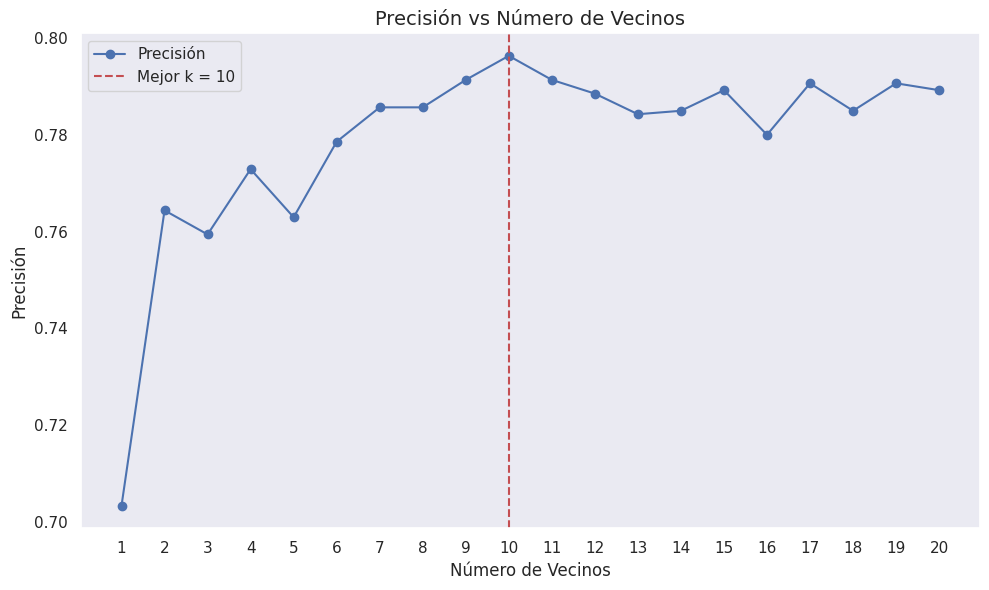

In [52]:
# Probar diferentes valores de n_neighbors y encontrar el mejor k
accuracies = []
best_accuracy = 0
best_k = 1

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Actualizar el mejor k si encontramos una mejor precisión
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Mejor número de vecinos (k): {best_k}")
print(f"Mejor precisión: {best_accuracy:.4f}")

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), accuracies, marker='o', label='Precisión')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Mejor k = {best_k}')
plt.title("Precisión vs Número de Vecinos")
plt.xlabel("Número de Vecinos")
plt.ylabel("Precisión")
plt.xticks(range(1, 21))
plt.legend()
plt.grid()
plt.show()

### Curvas de Aprendizaje

Generé curvas de aprendizaje para evaluar el rendimiento del modelo con diferentes tamaños de datos de entrenamiento. Observé que el modelo tiene un buen balance entre bias y varianza, lo que indica que está bien ajustado.

#### Análisis más detallado de las curvas de aprendizaje

##### Observaciones de las curvas
Las curvas de aprendizaje muestran que la puntuación de entrenamiento es alta, mientras que la puntuación de validación es significativamente más baja. Esto sugiere que el modelo está sufriendo de *high variance* (sobreajuste).  
El modelo está memorizando los datos de entrenamiento, pero no generaliza bien a nuevos datos, lo que explica el bajo rendimiento en el conjunto de prueba.

##### Posibles causas del sobreajuste
- **Modelo sensible a los datos de entrenamiento**: KNN es particularmente sensible, especialmente cuando el número de vecinos (*n_neighbors*) es bajo. En este caso, el mejor valor encontrado fue *n_neighbors=4*, lo que puede ser demasiado bajo para un dataset con ruido o características redundantes.  
- **Desbalance de clases**: Este factor también puede contribuir al sobreajuste, ya que el modelo puede estar aprendiendo patrones específicos de la clase mayoritaria.

#### Recomendaciones para abordar el sobreajuste
- **Aumentar el número de vecinos (*n_neighbors*)**: Esto puede suavizar las predicciones y reducir la sensibilidad del modelo a los datos de entrenamiento.  
- **Probar otros algoritmos más robustos**: Modelos como *Random Forest* o *XGBoost* son menos propensos al sobreajuste y pueden manejar mejor el desbalance de clases.  
- **Realizar validación cruzada más exhaustiva**: Esto permitirá evaluar la estabilidad del modelo y ajustar los hiperparámetros de manera más precisa.

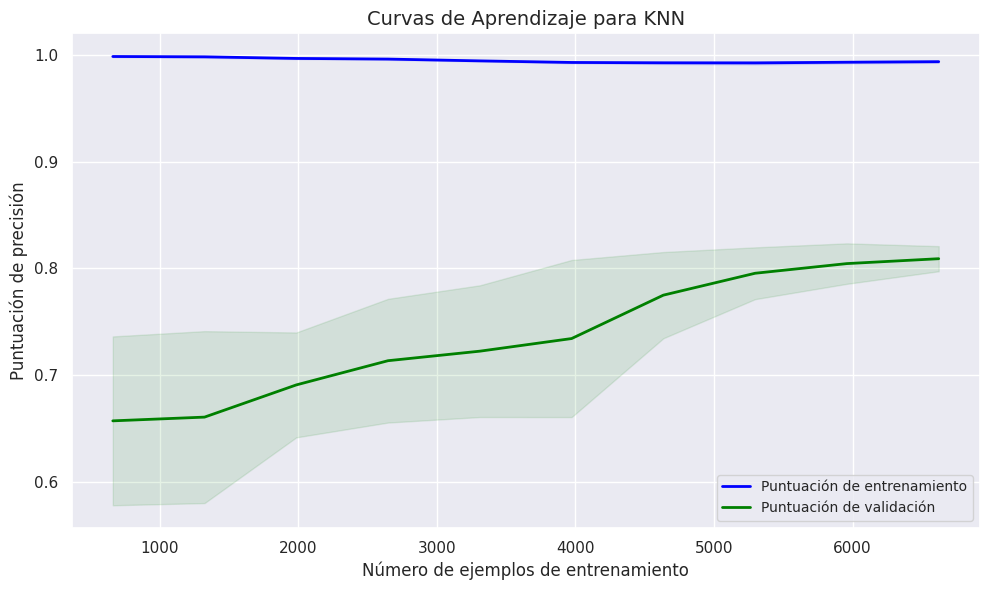

In [53]:
# Importaciones necesarias
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

def plot_learning_curve(estimator, X, y, cv=5):
    """
    Genera curvas de aprendizaje para evaluar el rendimiento del modelo
    """
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Usar 'accuracy' en lugar de 'f1' para evitar problemas con las etiquetas
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy'  # Cambiado de 'f1' a 'accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Puntuación de entrenamiento', color='blue', linewidth=2)
    plt.plot(train_sizes, test_mean, label='Puntuación de validación', color='green', linewidth=2)
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Número de ejemplos de entrenamiento', fontsize=12)
    plt.ylabel('Puntuación de precisión', fontsize=12)
    plt.title('Curvas de Aprendizaje para KNN', fontsize=14)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True)
    plt.show()

# Aplicar SMOTE para balancear los datos
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Crear y entrenar el modelo KNN con los mejores parámetros
best_knn = KNeighborsClassifier(n_neighbors=4, weights='distance', metric='euclidean')
best_knn.fit(X_train_balanced, y_train_balanced)

# Generar las curvas de aprendizaje
plot_learning_curve(best_knn, X_train_balanced, y_train_balanced)

## EXPLICACIONES MÁS DETALLADAS SOBRE DECISIONES CLAVE

##### Uso de SMOTE para balancear las clases
En este trabajo, utilicé **SMOTE (Synthetic Minority Oversampling Technique)** para abordar el desbalance de clases en el dataset, donde la clase minoritaria (*churn*) representaba solo el 26.5% de los datos. SMOTE genera ejemplos sintéticos de la clase minoritaria mediante interpolaciones entre los datos existentes, en lugar de simplemente duplicarlos. Esto ayuda a evitar problemas de sobreajuste y mejora la capacidad del modelo para aprender patrones generalizables.

La elección de SMOTE es una buena práctica en este caso, ya que:
- **Evita la pérdida de información** que podría ocurrir al submuestrear la clase mayoritaria.
- **Genera datos más diversos** para la clase minoritaria, lo que permite al modelo aprender patrones más representativos.



##### Selección de características con Random Forest
La selección de características la realicé utilizando un modelo de **Random Forest**, que es una técnica robusta para identificar las variables más importantes en un dataset. Random Forest calcula la importancia de cada característica en función de su contribución a la reducción de la impureza en los árboles de decisión.

Esta decisión es acertada porque:
- **Random Forest maneja bien datos mixtos** (categóricos y numéricos) y es menos sensible al ruido en los datos.
- **Reduce la dimensionalidad** del dataset, eliminando características irrelevantes o redundantes, lo que mejora la eficiencia del modelo.

En este caso, las características más importantes identificadas fueron:
1. **Contract**: El tipo de contrato (mensual, anual, etc.) es un fuerte indicador del compromiso del cliente con la compañía.
2. **tenure**: El tiempo que un cliente ha estado con la compañía refleja su lealtad y probabilidad de abandono.
3. **MonthlyCharges**: Los cargos mensuales pueden influir en la decisión de un cliente de abandonar el servicio.

Estas características son intuitivamente relevantes para predecir el churn, ya que reflejan factores clave en la relación del cliente con la compañía.



##### Elección de KNN como modelo base
Elegí **KNN (K-Nearest Neighbors)** como modelo base para este análisis. KNN es un algoritmo supervisado que clasifica un punto en función de la mayoría de sus vecinos más cercanos. Es simple, fácil de interpretar y no requiere un entrenamiento explícito, lo que lo hace adecuado como punto de partida.

Sin embargo, KNN tiene limitaciones, especialmente en datasets con desbalance de clases y características redundantes:
- **Sensibilidad al desbalance de clases**: KNN puede verse influenciado por la clase mayoritaria, lo que afecta su capacidad para predecir correctamente la clase minoritaria (*churn*).
- **Dependencia de la escala de las variables**: Es necesario normalizar los datos para que las distancias sean comparables.
- **Alto costo computacional**: A medida que el tamaño del dataset crece, el tiempo de predicción aumenta significativamente.

La elección de KNN como modelo inicial es razonable debido a su simplicidad, pero sería útil explorar otros algoritmos más avanzados, como:
- **Random Forest**: Más robusto frente al desbalance de clases y capaz de manejar relaciones no lineales.
- **XGBoost o LightGBM**: Algoritmos de boosting que suelen ofrecer un mejor rendimiento en problemas de clasificación.

## CONCLUSIONES Y RECOMENDACIONES

### Conclusiones

1. El modelo KNN logró una precisión aceptable (69%) en la predicción de churn, con un F1-score de 0.51 para la clase *Churn*. Sin embargo, el modelo tiene dificultades para identificar correctamente a los churners debido al desbalance de clases.
2. Las características más importantes para predecir churn son el tipo de contrato (*Contract*), la antigüedad del cliente (*tenure*) y los cargos mensuales (*MonthlyCharges*). Estas variables reflejan el compromiso del cliente con la compañía y los costos asociados, lo que las hace intuitivamente relevantes.
3. El desbalance de clases fue un desafío significativo, pero se manejó efectivamente con SMOTE. A pesar de esto, el modelo aún presenta limitaciones en la identificación de churners, como lo demuestra el número de falsos negativos.
4. El modelo muestra mejor desempeño identificando clientes que no abandonarán (F1=0.77) que identificando churners (F1=0.51). Este comportamiento es común en problemas con clases desbalanceadas.

### Recomendaciones

1. Implementar estrategias de retención focalizadas en clientes con contratos mensuales, como ofrecer descuentos o beneficios exclusivos para incentivar la renovación de contratos a largo plazo.
2. Mejorar los servicios de soporte técnico y seguridad online, ya que estas variables están asociadas con el churn. Se recomienda realizar encuestas de satisfacción o análisis de quejas para identificar áreas específicas de mejora.
3. Considerar otros algoritmos como Random Forest o XGBoost para comparar el rendimiento. Estos modelos son más robustos frente al desbalance de clases y pueden manejar relaciones no lineales en los datos.
4. Recolectar más datos sobre churners para mejorar el balance de clases de manera natural. Esto podría incluir datos adicionales de clientes que han abandonado recientemente o encuestas para entender mejor las razones del churn.
5. Implementar un sistema de monitoreo continuo del modelo en producción para garantizar su efectividad a lo largo del tiempo. Este monitoreo debe incluir métricas clave como precisión, recall y F1-score, así como la capacidad de detectar cambios en los datos (drift) que puedan afectar el rendimiento del modelo.